In [1]:
# IMPORTS

from math import sqrt, exp 

import random 

import numpy as np 

from time import time

import matplotlib.pyplot as plt


In [88]:
# DATA FOR THE INITIAL MATRIX OR "COLONY FRONT"

step_number = 100 # the number of Montecarlo steps in the simulation

event_density = 0.5 #a factor to correct the number of tries per step

max_density = 4 # stablish a maximum ocupation density for an space, find correlations with experimental data 

column_number = 10 # number of columns or  length (L) of the interface

slope = 1
# slope of the interface. 0 is a regular front. 1 is a tilting angle og 45°. 
#REMEMBER: Increase number of rows with increasing slope

initial_rows = 4 # initial rows of the front/colony or height (H) of the interface

initial_density = 2 # initial density of the colony
#REMEMBER: could randomnize this in future

cell_motility = 1 # number of squares a cell can move

beta = 30 # in exp(-beta*deltaE) determines if a cell moves or not, could depend on experiment

proliferation_motility_ratio = 0.2 # percentage of cells that try to proliferate each montecarlo step

cell_number = 0 # variable to count the cell number

cell_attachment = 1 # The interaction of cells between them, decreasing the value would lead to cell leaving the front
# a value of 1 correspond to cells that will always move mantaining at least un neighbour
# a value of 0.8 indicates that 20%  of the movements that lead to losing all the neighbours will be accepted
#REMEBER: think more complex equations for describing this

tries_per_step = 0.1 # the rate of movement/proliferation tries that we will have per step
# a factor of 1 indicates that we will have a try per cell
# a factor of 0.5 indicates that half of the cells will try to move or proliferate

saving_rate = 50 # how often will save the data and images
#REMEMBER: correlate this with experimental data, for example 50 steps ~ 8 hours of growth

discard_cells = 0 # to discard the cells on the back of the front

start_at_row = 0 # to move the row and leave behind the cells on the back, the "bulk" of the colony

row_number = int(column_number*slope)+initial_rows+1 # number of rows 

extra_row = [[0 for column in range(column_number)]]


In [89]:
possible_front

array([[0, 2, 0, 3, 0, 3, 0, 3, 4, 0],
       [4, 4, 4, 1, 1, 5, 1, 4, 1, 0],
       [5, 1, 0, 3, 2, 2, 0, 3, 3, 0],
       [3, 0, 2, 2, 3, 1, 3, 0, 3, 3],
       [0, 3, 4, 2, 5, 3, 0, 4, 0, 2],
       [2, 0, 3, 3, 3, 0, 0, 3, 4, 1],
       [0, 0, 1, 0, 2, 0, 6, 4, 3, 0],
       [2, 0, 0, 0, 2, 3, 0, 1, 1, 3],
       [1, 0, 0, 0, 0, 3, 2, 6, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 3, 7],
       [0, 0, 0, 0, 0, 0, 1, 4, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [90]:
# CREATION OF THE INITIAL MATRIX OR "COLONY FRONT"

# real_front contains the real matrix
real_front = np.array([[0 for column in range(column_number)] for row in range(row_number)])

# possible_front contains the possible configuration
possible_front = np.array([[0 for column in range(column_number)] for row in range(row_number)])

#Fills the fronts
for column in range(column_number):
    for row in range(int(column*slope)+initial_rows): # adjust by front slope
        cell_number = cell_number + initial_density
        real_front[row][column] = initial_density
        possible_front[row][column] = initial_density
        cell_number = cell_number + initial_density


In [91]:
# FUNCTIONS FOR ARRAYS

def gradient(array): 
    """
    Receives an array, calculates the gradient and returns its module
    """
    gradient = np.gradient(array) 
    return np.linalg.norm(gradient) 

def print_array(array):
    """
    Receives an array and prints it as a grid
    """
    for row in array:
        print(*row, sep="\t")

In [92]:
# FUNCTIONS FOR PLOTS

def plot_front(array):
    plt.imshow(array,
        cmap='viridis', aspect = "equal",
        interpolation = "none", 
        vmin = 0, vmax = max_density)
    plt.grid(True)

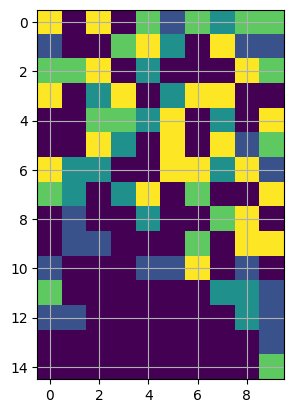

In [99]:
plot_front(real_front)

In [94]:
no_neighbours(possible_front, 2, 1000)

True

In [95]:
# FUNCTIONS FOR COUNTING NEIGHBOUR NUMBER

def no_neighbours(possible_front, new_row, new_column): 
    """
    Calculates the number of first and second neighbours
    """
    first_neighbours = 0 
    #second_neighbours = 0 
    
    # loop over posible neighbour positions
    for i in (-1,0,1): 
        for j in (-1,0,1):
            new_row2 = new_row + i #row of the possible new neighbour
            new_column2 = new_column + j #column of the possible new neighbour

            if new_row2 < 0: 
                new_row2 = 0 #just to not break the code, que assume we are in bulk region
            #If it is larger than the number of rows in the front, that spot would be empty
            
            #For periodic boundary conditions
            if new_column2 >= column_number:
                new_column2 = new_column2-column_number
                if slope != 0:
                    new_row2 = new_row2 - int(column_number*slope)
            elif new_column2 < 0:
                new_column2 = new_column2 + column_number
                if slope != 0:
                    new_row2 = new_row2 + int(column*slope)

            if not (i == 0 and j == 0): #just to not verify the same position
                try:
                    if possible_front[new_row2][new_column2]>0: 
                        #if one of them is 0, we are talking about a first neighbour
                        #first_neighbours = first_neighbours + 1
                        return False 
                #elif frente[new_row2][new_column2]>0 and (i != 0 and j != 0): #this would be a seond or diagonal neighbour
                    #second_neighbours = second_neighbours +1  
                except:
                    continue
    return True

In [98]:
%%time

for step in range(step_number):
    
    tries = 0
    
    #correct for the possibility of events ocurring on empty spaces of the grid
    empty_factor = real_front.size / np.count_nonzero(real_front)
    
    events = cell_number * empty_factor * event_density
    
    i = random.randint(start_at_row, len(possible_front)-1) 
    j = random.randint(0,column_number-1)
    
    while tries < events:     
        
        random_number = random.uniform(0,1)  
        
        tries = tries + 1

        if random_number < proliferation_motility_ratio:  
            if  max_density > possible_front[i][j] > 0:
                possible_front[i][j] = possible_front[i][j]+1
                cell_number = cell_number + 1
        else: 
            if possible_front[i][j] > 0:
                row_movement = random.randint(-cell_motility,cell_motility)
                column_movement = random.randint(-cell_motility,cell_motility)  
                
                new_row = i + row_movement
                new_column = j + column_movement
                    
                #If new row is negative, assigns it to be zero, we are still in the bulk
                if new_row < 0:
                    new_row = 0
                
                #Then corrects if columns are out of range, consider periodic boundary conditions
                if new_column >= column_number:
                    new_column = new_column - column_number
                    if slope != 0:
                        new_row = new_row - int(column_number*slope)
                elif new_column < 0:
                    new_column = new_column + column_number
                    if slope != 0:
                        new_row = new_row + int(column*slope)
                        
                #Add new empty row if needed
                while new_row > (len(possible_front) -1):
                    possible_front = np.vstack([possible_front, extra_row])
                
                possible_front[i][j] = possible_front[i][j]-1
                possible_front[new_row][new_column] = possible_front[new_row][new_column]+1
                
                if no_neighbours(possible_front, new_row, new_column):
                    possible_front = real_front
                
            #If the gradient diminishes, the cell movement is accepted
            if gradient(real_front) < gradient(possible_front):
                possible_front = real_front
            else:
                real_front = possible_front
            
            tries = tries + 1

CPU times: user 1.72 s, sys: 5.33 ms, total: 1.73 s
Wall time: 1.72 s


In [ ]:


                 #al némero de células en el casillero sorteado le resta la célula que se mueve



                 #al casillero donde se 
                #movería la célula se le suma 1
                E2 = calcular_módulo(frente2) #calcula el modulo del gradiente del frente que se obtendría con la nueva configuración

                DeltaE = E2 - E1 #calculo y guardo el DeltaE

                if numero_vecinos(numero_filas, numero_columnas, nueva_fila, nueva_columna, frente):  #si la célula mantiene al 
                    #menos 1 primer vecino

                    if DeltaE <= 0: #si el DeltaE es igual o menor que 0, acepto la nueva configuración
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1 #al frente se le suma una célula 
                        #en la nueva posición
                        frente[i][j] = frente[i][j]-1 #se le resta la célula que se mueve
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas): #con esto voy acumulando las células que le 
                                        #tengo que ir restando al contador de eventos porque las fui dejando atrás
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]


                    elif random.uniform(0,1) < (exp(-1*beta*DeltaE)): #si el DeltaE es positivo, el movimiento no disminuye el 
                        #gradiente y va a ser aceptado o rechazado con cierta probabilidad
                        #la probabilidad de aceptación depende de cuan positivo sea DeltaE y cuál sea al valor de beta
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1 #si el movimiento es aceptado, 
                        #se actualiza el frente
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    else: #si el movimiento no es aceptado, el frente2 se corrije para volver a ser igual al frente
                        frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                        frente2[i][j] = frente2[i][j]+1

                elif random.uniform(0,1) > adhesion_celular: #si la célula no mantiene primeros vecinos es como 
                    #si se estuviera despegando del frente
                    #en ese caso tiene que haber un sorteo, y si el sorteo supera el valor de adhesión celular, 
                    #se le permite a la célula moverse

                    if DeltaE <= 0: #IDEM arriba
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    elif random.uniform(0,1) < (exp(-1*beta*DeltaE)):
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    else:
                        frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                        frente2[i][j] = frente2[i][j]+1

                else: #si por no tener vecinos la célula no se mueve, se devuelve el frente2 a la configuración anterior
                    frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                    frente2[i][j] = frente2[i][j]+1


print("Terminado")


In [ ]:
tiempo = time()

#tiempostr = str(time())+".txt"

#ultima_fila_max = filas_iniciales_del_frente + 1

#ultima_fila_max = ultima_fila_max - 1 #tengo que definirlo así para que me apunten a espacios de memoria distintos

"""
fdata = open("data" + tiempostr,"a")
fdata.write("numero de columnas = ")
fdata.write(str(numero_columnas))
fdata.write("\n")
fdata.write("numero de filas = ")
fdata.write(str(numero_filas))
fdata.write("\n")
fdata.write("densidad maxima = ")
fdata.write(str(densidad_maxima))
fdata.write("\n")
fdata.write("densidad inicial = ")
fdata.write(str(densidad_inicial))
fdata.write("\n")
fdata.write("pendiente = ")
fdata.write(str(pendiente))
fdata.write("\n")
fdata.write("filas iniciales del frente = ")
fdata.write(str(filas_iniciales_del_frente))
fdata.write("\n")
fdata.write("movilidad celulas = ")
fdata.write(str(movilidad_celulas))
fdata.write("\n")
fdata.write("beta = ")
fdata.write(str(beta))
fdata.write("\n")
fdata.write("factor duplicacion = ")
fdata.write(str(factor_duplicación))
fdata.write("\n")
fdata.write("adhesion celular = ")
fdata.write(str(adhesion_celular))
fdata.write("\n")
fdata.write("factor intento por paso = ")
fdata.write(str(factor_intentos_por_paso))
fdata.write("\n")
fdata.close()
"""

step_jump = 1

for step in range(step_number): # realiza el número de pasos de montecarlo deseados

    if 100 > step >= 10:
        step_jump = 2
    elif 1000 > step >= 100:
        step_jump = 20
    elif step >= 1000:
        step_jump = 200

    if p % salto_paso == 0:

        suma_filas = 0 #va a guardar en esta variable la suma de todas las ultimas filas ocupadas para luego calcular la altura promedio

        hco=[0]*numero_columnas    #creo una matriz donde guardaré las alturas con overhang

        hso=[0]*numero_columnas    #creo una matriz donde guardaré las alturas sin overhang

        hco_promedio = 0 #crea la variable donde guardaré la altura con overhang promedio

        hso_promedio = 0 #crea la variable donde guardaré la altura sin overhang promedio

        sumatoria_hco = 0 #creo las variables donde irá guardando la suma de las distintas alturas del frente con

        sumatoria_hso = 0 # y sin overhang

        recorrido = 0 #variable que me indica si se terminó de recorrer el frente o no, para obtener el contorno

        fila_inicial = 0 #indica desde que fila se comienza el recorrido

        columna_inicial = 0 #indica desde que columna se comienza el recorrido

        ultimo_movimiento = 1 #guarda el último movimiento, en este caso siempre se comienza con arriba

        frente3 = [[0] * numero_columnas for i in range(numero_filas)] #realizo una matriz igual a la del frente pero vacía, para ir guardando como 1 los espacios que se corresponden con bordes

        while recorrido == 0: #se hará un loop hasta que el valor de recorrido sea 1, es decir, se haya recorrido todo el borde

            if columna_inicial == numero_columnas -1: #si la columna inicial es la última columna del frente

                if frente[fila_inicial+1][columna_inicial] > 0: #sólo buscaremos intentar subir más filas

                    ##### NOTAR QUE DE ESTA MANERA NO SERÁ POSIBLE DETECTAR SALIENTES U OVERHANGS EN UNO DE LOS BORDES DEL FRENTE
                    ### POR AHORA NECESITO QUE SEA ASÍ PARA PODER PONER UN PUNTO FINAL AL BARRIDO

                    frente3[fila_inicial][columna_inicial] = 1 #Si encuentra un casillero ocupado, a esa posición en frente 3 le pone un 1
                    fila_inicial = fila_inicial + 1 #sube en 1 la fila inicial para evaluar luego más arriba

                else: #si la fila por encima de la que ya habíamos evaluado está vacía
                    frente3[fila_inicial][columna_inicial] = 1 #a la anterior le asignamos el valor de 1
                    recorrido = 1 #terminamos el recorrido, porque ya llegamos a la última fila ocupada de la última columna


            else: #si no estamos en la última columna
                if ultimo_movimiento == 1: #y el último movimiento fue hacia arriba
                    if columna_inicial >0 and frente[fila_inicial][columna_inicial-1]>0: #primero intentamos movernos hacia la izquierda, siempre y cuando exista una columna a la izquierda
                        frente3[fila_inicial][columna_inicial]=1 #en caso de haber, a la posición anterior le ponemos 1
                        columna_inicial = columna_inicial -1 #le restamos 1 a la variable de columna que uso para barrer
                        ultimo_movimiento = 2 #aclaro que el último movimiento que hice fue hacia la izquierda
                    elif frente[fila_inicial+1][columna_inicial]>0: #si no hay nada a la izquierda, intentará fijarse arriba
                        if columna_inicial > 0:#si estamos por encima de la columna inicial (para no llenar la columna inicial de 1)
                            frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial +1
                        ultimo_movimiento = 1
                    elif frente[fila_inicial][columna_inicial+1]>0: #si no hay nada, veremos a la derecha
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial +1
                        ultimo_movimiento = 3
                    elif frente[fila_inicial-1][columna_inicial]: #como última posibilidad, nos fijamos abajo, donde seguro hay algo porque el último movimiento había sido hacia arriba
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial -1
                        ultimo_movimiento = 4

                elif ultimo_movimiento == 2: #si el último movimiento no fue hacia arriba, testea si fue hacia la izquierda.
                    if frente[fila_inicial-1][columna_inicial]: #luego realizo el mismo procedimiento anterior, pero asignando las prioridades que correspondan
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial -1
                        ultimo_movimiento = 4
                    elif columna_inicial >0 and frente[fila_inicial][columna_inicial-1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial -1
                        ultimo_movimiento = 2
                    elif frente[fila_inicial+1][columna_inicial]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial +1
                        ultimo_movimiento = 1
                    elif frente[fila_inicial][columna_inicial+1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial +1
                        ultimo_movimiento = 3

                elif ultimo_movimiento == 3:
                    if frente[fila_inicial+1][columna_inicial]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial +1
                        ultimo_movimiento = 1
                    elif frente[fila_inicial][columna_inicial+1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial +1
                        ultimo_movimiento = 3
                    elif frente[fila_inicial-1][columna_inicial]:
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial -1
                        ultimo_movimiento = 4
                    elif columna_inicial >0 and frente[fila_inicial][columna_inicial-1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial -1
                        ultimo_movimiento = 2

                elif ultimo_movimiento == 4:
                    if frente[fila_inicial][columna_inicial+1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial +1
                        ultimo_movimiento = 3
                    elif frente[fila_inicial-1][columna_inicial]:
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial -1
                        ultimo_movimiento = 4
                    elif columna_inicial >0 and frente[fila_inicial][columna_inicial-1]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        columna_inicial = columna_inicial -1
                        ultimo_movimiento = 2
                    elif frente[fila_inicial+1][columna_inicial]>0:
                        frente3[fila_inicial][columna_inicial]=1
                        fila_inicial = fila_inicial +1
                        ultimo_movimiento = 1


        frente4 = [[0] * numero_columnas for i in range(numero_filas)]

        for j in range(numero_columnas): #ahora voy a recorrer el frente 3, para recortar el frente y dejar sólo los células que componen la "tierra", hasta el borde
            unos = 0 #creo la variable unos donde guardaré el número de 1 que se encuentra recoriendo el frente
            for i in range(ultima_fila_max): #en filas recorre hasta la que sabemos es la última ocupada
                if frente3[i][j] == 1: #y voy sumando el número de 1 que aparecen como parte del frente
                    unos = unos +1

            hay_uno = 0 #inicializo la variable hay_uno, que vamos a usarla como contador
            for i in range(ultima_fila_max): #recorro nuevamente las filas
                if hay_uno != unos: #si hay_uno es distinto del número de 1 que sabemos que hay voy a copiar los valores en el frente4
                #si hay_uno alcanza el número de unos, quiere decir que llegamos al borde del frente y el resto deberían ser 0
                    if hay_uno%2 == 0: #y si el resto de la división de hay_uno por 2 es igual a 0, es decir, el primer 1 va a ser el borde del frente
                        #si luego aparece otro 1 es un overhang. En ese caso entre los dos 1, tienen que haber ceros (0) y el resto entre ellos va a ser 1
                        frente4[i][j]= frente[i][j] * 1 #si el resto es 0, a frente4 que va a ser el frente recortado, le doy el valor que tiene el frente en ese punto
                    if frente3[i][j]==1: #si el valor de frente3 es igual a 1, se trata de uno borde de colonia u overhang
                        hay_uno = hay_uno + 1 #en ese caso le sumamos 1 al contador hay_uno
                        frente4[i][j] = frente[i][j] * 1 #y le asignamos a esa posición de frente4 el valor de frente

        for j in range(numero_columnas): #voy a recorrer el numero de columnas y filas para saber cuantas celulas hay y cual es la mayor fila ocupada

            filas_ocupadas = 0 #crea la variable donde voy a ir guardando la cantidad de filas ocupadas, osea, SIN OVERHANG

            ultima_fila_ocupada = 0 #crea la variable donde voy a guardar la ultima fila ocupada, independientemente de si para llegar a estas hay espacios en blanco o no, osea, CON OVERHANG Â¡Â¡Â¡CHEQUEAR!!!

            for i in range(ultima_fila_max): #recorre el numero de filas para contar las celulas del frente y ver cual es la mayor fila ocupada

                if frente4[i][j]>0: #si el casillero tiene un número mayor a 0, está ocupado, más allá de si está en contacto o no con el frente !!!!!!!!!!
                    filas_ocupadas = filas_ocupadas + 1 #va agregando uno por cada fila ocupada
                    ultima_fila_ocupada = i + 1

            hco[j] = ultima_fila_ocupada #asigna a cada numero de columna la altura en filas con overhang

            hso[j] = filas_ocupadas #asigna a cada número de columna el número de filas ocupadas o altura sin overhang

            sumatoria_hco = sumatoria_hco + hco[j] #realizao la sumatoria de las alturas de cada columna para luego dividir por el número de columnas y obtener la altura promedio

            sumatoria_hso = sumatoria_hso + hso[j]


        hco_promedio = sumatoria_hco / float(numero_columnas) #altura promedio con overhang

        hso_promedio = sumatoria_hso / float(numero_columnas) #altura promedio sin overhang

        """
        rugosidad w

        w (t) = sqrt[1/N*sumatoria(h(t)-hpromedio)cuadrado]

        """

        suma_cuadrados_hco = 0 #creamos las variables para guardar las sumatoria de las desviaciones de alturas co y so, y las seteamos a 0 todos los pasos

        suma_cuadrados_hso = 0

        rugosidad_co = 0 #creamos las variables para guardar los valores de rugosidad y los seteamos a 0 todos los pasos

        rugosidad_so = 0


        for j in range(numero_columnas): #barriendo en las columnas
            suma_cuadrados_hco = suma_cuadrados_hco + (hco[j] - hco_promedio)**2 #sumamos los cuadrados de las desviaciones de las alturas
            suma_cuadrados_hso = suma_cuadrados_hso + (hso[j] - hso_promedio)**2

        rugosidad_co = sqrt(suma_cuadrados_hco/numero_columnas) #calculamos la rugosidad utilizando la función sqrt

        rugosidad_so = sqrt(suma_cuadrados_hso/numero_columnas)


        f = open(tiempostr,"a")
        f.write(str(time()))
        f.write(" ")
        f.write(str(p))
        f.write(" ")
        f.write(str(numero_celulas))
        f.write(" ")
        f.write(str(hco_promedio))
        f.write(" ")
        f.write(str(hso_promedio))
        f.write(" ")
        f.write(str(rugosidad_co))
        f.write(" ")
        f.write(str(rugosidad_so))
        f.write("\n")
        f.close()



    if p % cada_cuanto_guarda == 0:

        """
        fr = open(str(tiempo)+" "+str(p)+".txt","a")
        fr.write("\n")
        for i in range(numero_filas):
            for j in range(numero_columnas):
                fr.write(str(frente4[i][j])+" ")
            fr.write("\n")
        fr.close()
        """

        plt.imshow(numpy.asarray(frente), cmap='viridis', aspect = "equal", interpolation = "none", vmin = 0, vmax = densidad_maxima)

        plt.savefig(str(tiempo)+" "+str(p) + "frente.pdf", bbox_inches='tight', transparent = "True", frameon = "False")


        plt.imshow(numpy.asarray(frente4), cmap='viridis', aspect = "equal", interpolation = "none", vmin = 0, vmax = densidad_maxima)

        plt.savefig(str(tiempo)+" "+str(p)+ "frente4.pdf", bbox_inches='tight', transparent = "True", frameon = "False")


    conteo_numero_celulas = numero_columnas * filas_iniciales_del_frente * densidad_inicial * factor_intentos_por_paso #int((numero_celulas - celulas_restar) * factor_intentos_por_paso)


    while conteo_numero_celulas > 0: #van a haber tantos intentos como células en el frente

        sorteo = random.uniform(0,1) #sortea de antemano si va a ocurrir un posible evento de duplicaciòn o uno de movilidad

        E1 = calcular_módulo(frente) #calcula el módulo del gradiente del frente para utilizar luego

        if sorteo < factor_duplicación : #si el sorteo cae en cierto rango de valores, quizà ocurre una duplicaciòn (habrà que ajustar el intervalo)
            i = random.randrange(empezar_por_fila, ultima_fila_max) #sortea una posible fila
            j = random.randrange(numero_columnas) #sortea una posible columna

            if frente[i][j] > 0: #and numero_vecinos(numero_filas, numero_columnas, i, j, frente): #se fija si hay una célula en el lugar para ver si realiza una duplicación, y tambión si ya ha alcanzado la densidad celular máxima

                conteo_numero_celulas = conteo_numero_celulas - 1 #le resto 1 al número de células para terminar en algún momento el loop while


                if densidad_maxima >= frente[i][j] and numero_vecinos(numero_filas, numero_columnas, i, j, frente):


                    frente[i][j] = frente[i][j]+1 #a la posición sorteada de los frentes le sumo 1

                    frente2[i][j] = frente2[i][j]+1

                    numero_celulas = numero_celulas + 1 #aumenta en 1 el número de células

                """
                if random.uniform(0,1) < (frente[i][j]/densidad_maxima) and densidad_maxima > frente[i][j]: #con esto intentamos dos cosas:

                    #primero que la densidad de un casillero nunca supere la densidad máxima

                    #segundo, que ocurran más eventos de duplicación en los casilleros más poblados y menos en los menos poblados (que pueden ser células desprendidas del frente que me generan islas)

                    frente[i][j] = frente[i][j]+1 #a la posición sorteada de los frentes le sumo 1

                    frente2[i][j] = frente2[i][j]+1

                    numero_celulas = numero_celulas + 1 #aumenta en 1 el número de células


                Esto estaba pensado para intentar disminuir la formación de islas, pero cambia el exponente del escalado de 0.33 a 0.25
                """

        else: #

            i = random.randrange(empezar_por_fila, ultima_fila_max) #sortea una posible fila, entre la primera donde quiero empezar a ver eventos y la última ocupada
            j = random.randrange(numero_columnas) #sortea una posible columna
            diferencia_ultima_fila_max_nueva_fila = 0 #variable donde voy a guardar la diferencia entre la ultima fila max y la nueva fila, para agregar el numero de filas que corresponda

            if frente[i][j] > 0: #si en ese lugar hay una célula

                conteo_numero_celulas = conteo_numero_celulas - 1 #le resta 1 al contador, independientemente de que se produzca o no movimiento

                desplazamiento_fila = (random.randrange(1+2*movilidad_celulas))-movilidad_celulas #sortea para ver a donde se movera la celula, la resta se incluye para que puedan existir numeros negativos
                desplazamiento_columna = (random.randrange(1+2*movilidad_celulas))-movilidad_celulas

                frente2[i][j] = frente2[i][j]-1 #al némero de células en el casillero sorteado le resta la célula que se mueve

                nueva_fila = i+desplazamiento_fila #defino cual será la nueva fila que ocuparía la célula si se mueve
                nueva_columna = j+desplazamiento_columna #defino cual será la nueva columna que ocupará la célula si se mueve

                if nueva_fila >= numero_filas: #si la nueva fila tiene un índice mayor al número de filas (recordar que python empieza a contar desde 0)
                    nueva_fila = numero_filas-1 #defino a la nueva fila como la ultima fila (total nunca el frente debería llegar a recorrer todo el espacio, y debería estar ocupado por ceros)
                    print("Te quedaste corto con la cápsula!!!")

                elif nueva_fila < 0: #la posición no puede ser negativa
                    nueva_fila = 0 #asigno a la nueva fila la fila 0, total ahí  todo el frente debería estar lleno de células, es la región del bulk

        #


                if nueva_columna >= numero_columnas: # si la célula intenta irse por la derecha, debería aparecer por la izquierda, es mi condición de borde
                    nueva_columna = nueva_columna-numero_columnas #con esto le hago dar la vuelta, si el frente tiene 10 columnas, el indice de la ultima será 9. Si nueva columna es 10, y le resto 10, la nueva posición será la 0

                elif nueva_columna < 0:
                    nueva_columna = nueva_columna + numero_columnas #así, si cae en la posicion -1 y le sumo 10, pasaría a estar en la 9



                frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]+1 #al casillero donde se movería la célula se le suma 1
                E2 = calcular_módulo(frente2) #calcula el modulo del gradiente del frente que se obtendría con la nueva configuración

                DeltaE = E2 - E1 #calculo y guardo el DeltaE

                if numero_vecinos(numero_filas, numero_columnas, nueva_fila, nueva_columna, frente):  #si la célula mantiene al menos 1 primer vecino

                    if DeltaE <= 0: #si el DeltaE es igual o menor que 0, acepto la nueva configuración
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1 #al frente se le suma una célula en la nueva posición
                        frente[i][j] = frente[i][j]-1 #se le resta la célula que se mueve
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas): #con esto voy acumulando las células que le tengo que ir restando al contador de eventos porque las fui dejando atrás
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]


                    elif random.uniform(0,1) < (exp(-1*beta*DeltaE)): #si el DeltaE es positivo, el movimiento no disminuye el gradiente y va a ser aceptado o rechazado con cierta probabilidad
                        #la probabilidad de aceptación depende de cuan positivo sea DeltaE y cuál sea al valor de beta
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1 #si el movimiento es aceptado, se actualiza el frente
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    else: #si el movimiento no es aceptado, el frente2 se corrije para volver a ser igual al frente
                        frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                        frente2[i][j] = frente2[i][j]+1

                elif random.uniform(0,1) > adhesion_celular: #si la célula no mantiene primeros vecinos es como si se estuviera despegando del frente
                    #en ese caso tiene que haber un sorteo, y si el sorteo supera el valor de adhesión celular, se le permite a la célula moverse

                    if DeltaE <= 0: #IDEM arriba
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    elif random.uniform(0,1) < (exp(-1*beta*DeltaE)):
                        frente[nueva_fila][nueva_columna] = frente[nueva_fila][nueva_columna]+1
                        frente[i][j] = frente[i][j]-1
                        if (nueva_fila+1) > ultima_fila_max: #si la nueva fila de la célula está por encima de todas las filas anteriores
                                diferencia_ultima_fila_max_nueva_fila = ultima_fila_max - nueva_fila +1 #le doy un valor a la diferencia
                                ultima_fila_max = nueva_fila + 1 #esa nueva fila pasa a ser la fila máxima
                                for i in range(diferencia_ultima_fila_max_nueva_fila):
                                    frente.append([0] * numero_columnas) #si la diferencia es uno, agrego una fila, si es dos, agrego 2
                                    frente2.append([0] * numero_columnas)
                                    numero_filas = numero_filas+1
                                    empezar_por_fila = empezar_por_fila + 1
                                    for j in range(numero_columnas):
                                        celulas_restar = celulas_restar + frente[empezar_por_fila][j]

                    else:
                        frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                        frente2[i][j] = frente2[i][j]+1

                else: #si por no tener vecinos la célula no se mueve, se devuelve el frente2 a la configuración anterior
                    frente2[nueva_fila][nueva_columna] = frente2[nueva_fila][nueva_columna]-1
                    frente2[i][j] = frente2[i][j]+1


print("Terminado")
